In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

import admix
import numpy as np
import pandas as pd
import admix_prs
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [2]:
DATA_DIR = "./out"
PHENO_DIR = "/u/project/sgss/UKBB/PRS-RESEARCH/03-compile-pheno/out"

In [3]:
COVAR_COLS = ["AGE", "SEX", "DEPRIVATION_INDEX"] + [f"PC{i}" for i in range(1, 10)]
TEST_COLS = ["SEX", "glasses"] + [
    col + "_Q"
    for col in ["AGE", "years_of_edu", "income", "DEPRIVATION_INDEX", "PC1", "PC2"]
]
print("Covariates:", ", ".join(COVAR_COLS))
print("Testing:", ", ".join(TEST_COLS))

Covariates: AGE, SEX, DEPRIVATION_INDEX, PC1, PC2, PC3, PC4, PC5, PC6, PC7, PC8, PC9
Testing: SEX, glasses, AGE_Q, years_of_edu_Q, income_Q, DEPRIVATION_INDEX_Q, PC1_Q, PC2_Q


In [4]:
df_covar = pd.read_csv(os.path.join(DATA_DIR, "covar.tsv"), sep="\t", index_col=0)

# add some phenotype to the covariates
for trait in ["years_of_edu", "glasses", "income"]:
    df_trait = pd.read_csv(
        os.path.join(PHENO_DIR, f"{trait}.tsv"), sep="\t", index_col=0
    ).drop(columns=["IID"])
    df_covar[trait] = df_trait["PHENO"].reindex(df_covar.index)

# convert continuous phenotype to discrete phenotypes
for col in ["years_of_edu", "income", "AGE", "DEPRIVATION_INDEX", "PC1", "PC2"]:
    df_covar[f"{col}_Q"] = pd.qcut(df_covar[col], q=5, duplicates="drop").cat.codes

In [5]:
trait = "height"
df_trait = pd.read_csv(
    os.path.join(PHENO_DIR, f"{trait}.tsv"), sep="\t", index_col=0
).drop(columns=["IID"])

# add score
df_score = pd.read_csv(
    os.path.join(DATA_DIR, f"pred/{trait}.score_summary.tsv.gz"), sep="\t", index_col=0
)
df_score.index = [int(i.split("_")[0]) for i in df_score.index]
df_trait = pd.merge(df_score, df_trait, left_index=True, right_index=True)

# add covariates
df_trait = pd.merge(df_trait, df_covar, left_index=True, right_index=True)

# within single UK ancestry
df_trait = df_trait[df_trait.group == "United Kingdom"]
df_trait = df_trait.dropna()

df_trait["PHENO_RESID"] = (
    sm.OLS(
        df_trait["PHENO"].values, sm.add_constant(df_trait[COVAR_COLS]), missing="drop"
    )
    .fit()
    .resid
)

/u/project/pasaniuc/kangchen/software/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [6]:
df_res, df_res_se, r2_diff = admix_prs.summarize_pred(
    df_trait,
    y_col="PHENO_RESID",
    pred_col="MEAN",
    group_col="PC1_Q",
    n_bootstrap=99,
    return_r2_diff=True,
)

Bootstrapping: 100%|██████████| 99/99 [00:03<00:00, 32.60it/s]


,r2,std(y),std(pred)
PC1_Q,,,
0,0.369356,6.272018,4.260733
1,0.410593,6.242826,4.345118
2,0.383393,6.320861,4.293411
3,0.380624,6.204625,4.297306
4,0.390228,6.343696,4.251707


,r2,std(y),std(pred)
PC1_Q,,,
0,0.014573,0.092842,0.060208
1,0.013294,0.076182,0.052505
2,0.012788,0.089415,0.056127
3,0.013693,0.079033,0.056441
4,0.018353,0.097967,0.077389


Text(0.5, 1.0, 'p-value: 0.2')

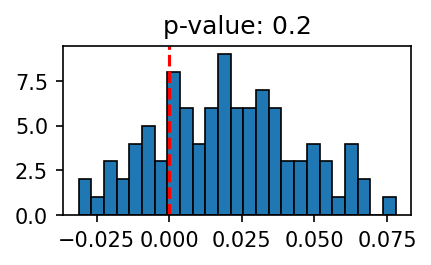

In [7]:
display(df_res)
display(df_res_se)

fig, ax = plt.subplots(figsize=(3, 1.5), dpi=150)
ax.hist(r2_diff, edgecolor="black", linewidth=0.8, bins=25)
ax.axvline(x=0, ls="--", color="r")
ax.set_title(f"p-value: {np.mean(r2_diff < 0):.2g}")

In [8]:
# TODO:
# have a notion of effect sizes, unit of R2 reductment per unit of covariate
# (maybe a simple grouped R2 would suffice (top quantile and bottom 5th quantile))